## 기초 설정, 데이터 로드


In [4]:
import numpy as np, pandas as pd, tensorflow as tf, random, math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import layers, models, callbacks, optimizers
import tensorflow.keras.backend as K

plt.rcParams['axes.unicode_minus'] = False
SEED = 42
np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)

# -------- 설정 --------
CSV = '/content/drive/MyDrive/TSLA.csv'
LOOKBACK = 60
H = 5
LR = 3e-4
BATCH = 64

# -------- 데이터 로드 --------
df = pd.read_csv(CSV)
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
df = df[['Open', 'High', 'Low', 'Close']].dropna().astype('float32')

## 기술적 지표 추가
- 이동평균 5/20일, 그리고 교차차(SMA_cross)로 골든/데드 크로스 신호
- 볼린저 밴드(20일 평균±2표준편차)와 현재 위치(BB_position)
- RSI(14) 계산: 상승/하락 평균으로 상대강도 지수
- 모멘텀 5/20일 수익률, 20일 이동 표준편차 기반 변동성(수익률 표준편차)
- prev_c: 전일 종가
- hl_range: (고–저)/종가 → 상대 일중 변동폭
- oc_gap: 시가–전일종가 차이의 비율
- 위 파생값과 지표들을 feat로 합쳐 float32 배열 구성(모델 입력)

In [5]:
# -------- 기술적 지표 추가 --------
def add_technical_features(df):
    df = df.copy()

    # 이동평균
    df['SMA_5'] = df['Close'].rolling(5).mean()
    df['SMA_20'] = df['Close'].rolling(20).mean()
    df['SMA_cross'] = df['SMA_5'] - df['SMA_20']  # 골든크로스/데드크로스

    # 볼린저 밴드
    rolling_mean = df['Close'].rolling(20).mean()
    rolling_std = df['Close'].rolling(20).std()
    df['BB_upper'] = rolling_mean + 2 * rolling_std
    df['BB_lower'] = rolling_mean - 2 * rolling_std
    df['BB_position'] = (df['Close'] - df['BB_lower']) / (df['BB_upper'] - df['BB_lower'] + 1e-8)

    # RSI
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = -delta.where(delta < 0, 0).rolling(14).mean()
    rs = gain / (loss + 1e-8)
    df['RSI'] = 100 - (100 / (1 + rs))

    # 모멘텀
    df['Momentum_5'] = df['Close'].pct_change(5)
    df['Momentum_20'] = df['Close'].pct_change(20)

    # 변동성
    df['Volatility'] = df['Close'].pct_change().rolling(20).std()

    return df.fillna(method='bfill').fillna(0)

df = add_technical_features(df)

# -------- 기본 특징 + 기술적 지표 --------
o = df['Open'].values
h = df['High'].values
l = df['Low'].values
c = df['Close'].values

prev_c = np.r_[c[0], c[:-1]]
hl_range = (h - l) / np.maximum(1e-6, c)
oc_gap = (o - prev_c) / np.maximum(1e-6, prev_c)

# 모든 특징 결합
feat = np.column_stack([
    o, h, l, c,
    hl_range, oc_gap,
    df['SMA_5'].values,
    df['SMA_20'].values,
    df['SMA_cross'].values,
    df['BB_position'].values,
    df['RSI'].values,
    df['Momentum_5'].values,
    df['Momentum_20'].values,
    df['Volatility'].values
]).astype('float32')

/tmp/ipython-input-889526596.py:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.fillna(method='bfill').fillna(0)


In [6]:
# -------- 타깃: 로그수익률 + 변동성 정규화 --------
logc = np.log(c + 1e-12)
y_raw = np.full_like(logc, np.nan, dtype='float32')
y_raw[:-H] = logc[H:] - logc[:-H]

# 변동성 고려한 정규화
rolling_vol = pd.Series(logc).diff().rolling(20).std().fillna(0.01).values
y_vol_adjusted = y_raw / (rolling_vol + 1e-8)

valid_upto = len(df) - H
feat = feat[:valid_upto]
y_raw = y_raw[:valid_upto]
y_vol_adjusted = y_vol_adjusted[:valid_upto]
close = c[:valid_upto]
rolling_vol = rolling_vol[:valid_upto]

In [7]:
# -------- 시계열 분할 --------
n = len(y_raw)
tr_ratio, va_ratio = 0.7, 0.15
n_tr = int(n * tr_ratio)
n_va = int(n * (tr_ratio + va_ratio))

# -------- X 표준화 --------
scalerX = StandardScaler().fit(feat[:n_tr])
X_all = scalerX.transform(feat).astype('float32')

# -------- y 표준화 --------
y_mean = float(np.nanmean(y_raw[:n_tr]))
y_std = float(np.nanstd(y_raw[:n_tr]) + 1e-8)
y_all = ((y_raw - y_mean) / y_std).astype('float32')

# -------- 윈도우 구성 --------
def make_seq(X, y, lookback, start, end):
    Xs, ys, base_idx = [], [], []
    for t in range(start + lookback, end):
        Xs.append(X[t-lookback:t])
        ys.append(y[t])
        base_idx.append(t-1)
    return np.array(Xs, dtype='float32'), np.array(ys, dtype='float32'), np.array(base_idx, dtype=int)

X_tr, y_tr, idx_tr = make_seq(X_all, y_all, LOOKBACK, 0, n_tr)
X_va, y_va, idx_va = make_seq(X_all, y_all, LOOKBACK, n_tr, n_va)
X_te, y_te, idx_te = make_seq(X_all, y_all, LOOKBACK, n_va, n)

# 샘플 가중치 (낮은 변동성 구간 강조)
volatility_tr = np.abs(y_raw[idx_tr])
sample_weights = 1.0 / (volatility_tr + 0.05)
sample_weights = sample_weights / sample_weights.mean()

print("Shapes:", X_tr.shape, X_va.shape, X_te.shape)

Shapes: (2005, 60, 14) (383, 60, 14) (383, 60, 14)


## 데이터 분포 진단
- 각 세트 y의 평균/표준편차, 상승/하락 비율, 범위 출력
- 타깃 스케일과 클래스(부호) 불균형 여부를 빠르게 확인

In [8]:
# -------- 데이터 분포 진단 --------
print("\n=== 데이터 분포 분석 ===")
print(f"Train - y 평균: {y_tr.mean():.4f}, 표준편차: {y_tr.std():.4f}")
print(f"Val   - y 평균: {y_va.mean():.4f}, 표준편차: {y_va.std():.4f}")
print(f"Test  - y 평균: {y_te.mean():.4f}, 표준편차: {y_te.std():.4f}")

print(f"\nTrain 상승/하락 비율: {(y_tr > 0).mean():.2%} / {(y_tr < 0).mean():.2%}")
print(f"Val   상승/하락 비율: {(y_va > 0).mean():.2%} / {(y_va < 0).mean():.2%}")
print(f"Test  상승/하락 비율: {(y_te > 0).mean():.2%} / {(y_te < 0).mean():.2%}")

# 극단값 체크
print(f"\nTrain y 범위: [{y_tr.min():.3f}, {y_tr.max():.3f}]")
print(f"Val   y 범위: [{y_va.min():.3f}, {y_va.max():.3f}]")
print(f"Test  y 범위: [{y_te.min():.3f}, {y_te.max():.3f}]")


=== 데이터 분포 분석 ===
Train - y 평균: 0.0029, 표준편차: 0.9794
Val   - y 평균: 0.0963, 표준편차: 1.4951
Test  - y 평균: 0.0687, 표준편차: 1.1404

Train 상승/하락 비율: 49.83% / 50.17%
Val   상승/하락 비율: 54.83% / 45.17%
Test  상승/하락 비율: 50.13% / 49.87%

Train y 범위: [-4.170, 5.893]
Val   y 범위: [-8.127, 6.300]
Test  y 범위: [-3.571, 3.419]


In [9]:
# -------- 방향성 강조 손실 함수 --------
def directional_loss(y_true, y_pred):
    # 기본 Huber 손실
    huber = tf.keras.losses.Huber()(y_true, y_pred)

    # 방향 불일치 페널티
    sign_true = tf.sign(y_true)
    sign_pred = tf.sign(y_pred)
    wrong_direction = tf.cast(tf.not_equal(sign_true, sign_pred), tf.float32)
    direction_penalty = wrong_direction * tf.abs(y_true - y_pred) * 1.5

    return huber + 0.4 * tf.reduce_mean(direction_penalty)

In [10]:
# -------- 출력 스케일 제약 --------
RET_SCALE = np.clip(1.5 * y_std, 0.01, 0.12)
def out_scale(x): return x * RET_SCALE

## 모델 구성

In [11]:
# -------- Attention 기반 개선 모델 --------
def build_attention_lstm(input_shape, units=96, dropout=0.4, l2_reg=0.005):
    inp = layers.Input(shape=input_shape)

    # Bidirectional LSTM
    x = layers.Bidirectional(
        layers.LSTM(
            units,
            return_sequences=True,
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            recurrent_regularizer=tf.keras.regularizers.l2(l2_reg)
        )
    )(inp)
    x = layers.LayerNormalization()(x)
    x = layers.Dropout(dropout)(x)

    # Attention mechanism (정규화 추가)
    attn = layers.Dense(1, activation='tanh',
                        kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    attn = layers.Activation('softmax')(attn)
    x_attn = layers.Multiply()([x, attn])
    x = layers.GlobalAveragePooling1D()(x_attn)

    # Residual connection
    x_skip = layers.GlobalAveragePooling1D()(inp)
    x = layers.Concatenate()([x, x_skip])

    # Dense layers (dropout 강화)
    x = layers.Dense(48, activation='relu',
                     kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(24, activation='relu',
                     kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(1, activation='tanh')(x)
    out = layers.Lambda(out_scale)(x)

    model = models.Model(inp, out)
    model.compile(
        optimizer=optimizers.Adam(LR),
        loss=directional_loss,
        metrics=['mae']
    )
    return model

In [12]:
# -------- LSTM --------
def build_improved_lstm(input_shape, units=64, dropout=0.5, l2_reg=0.01):
    """과적합 방지를 위해 모델을 대폭 간소화"""
    inp = layers.Input(shape=input_shape)

    # 단일 LSTM 레이어 (Stacked 제거)
    x = layers.LSTM(
        units,
        recurrent_dropout=0.2,
        kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
        recurrent_regularizer=tf.keras.regularizers.l2(l2_reg)
    )(inp)

    x = layers.LayerNormalization()(x)
    x = layers.Dropout(dropout)(x)

    # Dense 레이어 최소화
    x = layers.Dense(32, activation='relu',
                     kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(1, activation='tanh')(x)
    out = layers.Lambda(out_scale)(x)

    model = models.Model(inp, out)
    model.compile(
        optimizer=optimizers.Adam(LR * 0.5),  # 학습률도 절반으로
        loss=directional_loss,
        metrics=['mae']
    )
    return model

In [13]:
# -------- 콜백 (과적합 방지) --------
cbs = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,  # 더 빨리 멈춤
        restore_best_weights=True,
        verbose=1,
        min_delta=0.002  # 최소 개선폭 증가
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,  # 더 빨리 학습률 감소
        min_lr=1e-6,
        verbose=1
    )
]

## 학습

In [14]:
# -------- 모델 학습 --------
print("\n=== Training Attention LSTM ===")
attn_lstm = build_attention_lstm(X_tr.shape[1:])
attn_lstm.summary(line_length=120)
history_attn = attn_lstm.fit(
    X_tr, y_tr,
    sample_weight=sample_weights,
    validation_data=(X_va, y_va),
    epochs=200,
    batch_size=BATCH,
    shuffle=True,
    callbacks=cbs,
    verbose=1
)

print("\n=== Training Improved LSTM ===")
improved_lstm = build_improved_lstm(X_tr.shape[1:])
history_imp = improved_lstm.fit(
    X_tr, y_tr,
    sample_weight=sample_weights,
    validation_data=(X_va, y_va),
    epochs=200,
    batch_size=BATCH,
    shuffle=True,
    callbacks=cbs,
    verbose=1
)


=== Training Attention LSTM ===


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_layer_6 (InputLayer)        │ (None, 60, 14)               │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ bidirectional_3 (Bidirectional)   │ (None, 60, 192)              │            85,248 │ input_layer_6[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ layer_normalization_10            │ (None, 60, 192)              │               384 │ bidirectional_3[0][0]     
│ (LayerNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dropout_15 (Dropout)              │ (None, 60, 192)              │                 0 │ layer_normalization_10[0][
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dense_20 (Dense)                  │ (None, 60, 1)                │               193 │ dropout_15[0][0]          
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ activation_3 (Activation)         │ (None, 60, 1)                │                 0 │ dense_20[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ multiply_3 (Multiply)             │ (None, 60, 192)              │                 0 │ dropout_15[0][0],         
│                                   │                              │                   │ activation_3[0][0]        
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ global_average_pooling1d_6        │ (None, 192)                  │                 0 │ multiply_3[0][0]          
│ (GlobalAveragePooling1D)          │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ global_average_pooling1d_7        │ (None, 14)                   │                 0 │ input_layer_6[0][0]       
│ (GlobalAveragePooling1D)          │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ concatenate_5 (Concatenate)       │ (None, 206)                  │                 0 │ global_average_pooling1d_6
│                                   │                              │                   │ global_average_pooling1d_7
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dense_21 (Dense)                  │ (None, 48)                   │             9,936 │ concatenate_5[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dropout_16 (Dropout)              │ (None, 48)                   │                 0 │ dense_21[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dense_22 (Dense)                  │ (None, 24)                   │             1,176 │ dropout_16[0][0]          
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dropout_17 (Dropout)              │ (None, 24)        

 Total params: 96,962 (378.76 KB)

 Trainable params: 96,962 (378.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 60, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - loss: 2.3004 - mae: 0.7379 - val_loss: 2.3583 - val_mae: 1.0419 - learning_rate: 3.0000e-04
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - loss: 1.9581 - mae: 0.7339 - val_loss: 2.1587 - val_mae: 1.0414 - learning_rate: 3.0000e-04
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - loss: 1.7050 - mae: 0.7367 - val_loss: 1.8602 - val_mae: 1.0402 - learning_rate: 3.0000e-04
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - loss: 1.4911 - mae: 0.7341 - val_loss: 1.7240 - val_mae: 1.0407 - learning_rate: 3.0000e-04
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - loss: 1.3273 - mae: 0.7354 - val_loss: 1.6234 - val_mae: 1.0403 - learning_rate: 3.0000e-04
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - loss: 1.1966 - mae: 0.7358 - val_loss: 1.5297 - val_mae: 1.0397 - learning_rate: 3.0000e-04
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - loss: 1.0842 - mae: 0.7356 - val_loss: 1.4715 - val_mae: 1.0416 - learning

In [15]:
# -------- 앙상블 예측 --------
def ensemble_predict(models, X):
    preds = [m.predict(X, verbose=0) for m in models]
    return np.mean(preds, axis=0)

# -------- 보조 함수 --------
def inv_to_raw_return(y_hat_scaled):
    return y_hat_scaled * y_std + y_mean

def price_from_base_and_return(base_prices, r_vec):
    return base_prices * np.exp(r_vec)

base_prices_test = close[idx_te]
y_true_raw = (y_te * y_std) + y_mean
true_prices = price_from_base_and_return(base_prices_test, y_true_raw)

## 평가

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 60, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(



Attention LSTM (H=5)
Return  MAE: 0.061171 | RMSE: 0.080039 | Hit-rate: 0.548
Price   MAE: 46.214 | RMSE: 63.452


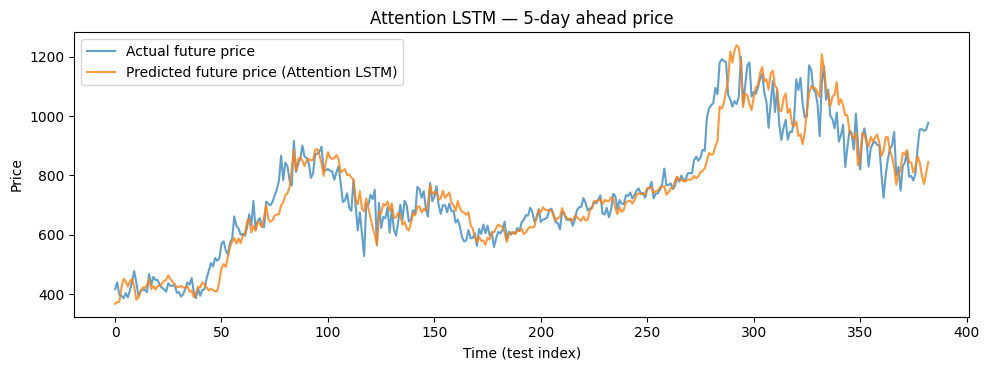


Improved LSTM (H=5)
Return  MAE: 0.061240 | RMSE: 0.080131 | Hit-rate: 0.548
Price   MAE: 46.239 | RMSE: 63.459


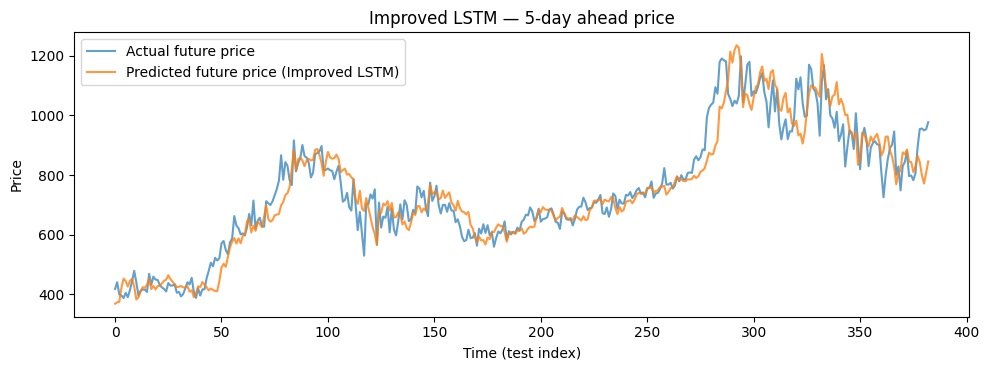


=== Ensemble Prediction ===

Ensemble (H=5)
Price   MAE: 46.227 | RMSE: 63.454 | Hit-rate: 0.548


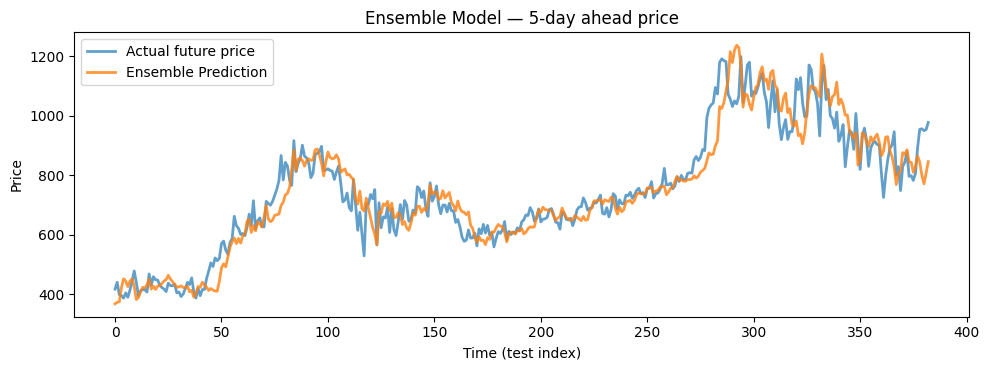

In [16]:
# -------- 평가 --------
def evaluate(model, name, X_test=X_te):
    yhat_scaled = model.predict(X_test, verbose=0).reshape(-1)
    yhat_raw = inv_to_raw_return(yhat_scaled)
    pred_prices = price_from_base_and_return(base_prices_test, yhat_raw)

    mse_p = mean_squared_error(true_prices, pred_prices)
    rmse_p = math.sqrt(mse_p)
    mae_p = mean_absolute_error(true_prices, pred_prices)

    mse_r = mean_squared_error(y_true_raw, yhat_raw)
    rmse_r = math.sqrt(mse_r)
    mae_r = mean_absolute_error(y_true_raw, yhat_raw)
    hit = float((np.sign(y_true_raw) == np.sign(yhat_raw)).mean())

    print(f"\n{name} (H={H})")
    print(f"Return  MAE: {mae_r:.6f} | RMSE: {rmse_r:.6f} | Hit-rate: {hit:.3f}")
    print(f"Price   MAE: {mae_p:,.3f} | RMSE: {rmse_p:,.3f}")

    # 플롯
    plt.figure(figsize=(10, 3.8))
    plt.plot(true_prices, label='Actual future price', alpha=0.7)
    plt.plot(pred_prices, label=f'Predicted future price ({name})', alpha=0.8)
    plt.title(f'{name} — {H}-day ahead price')
    plt.xlabel('Time (test index)')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return pred_prices, hit

# 개별 모델 평가
pred_attn, hit_attn = evaluate(attn_lstm, "Attention LSTM")
pred_imp, hit_imp = evaluate(improved_lstm, "Improved LSTM")

# 앙상블 평가
print("\n=== Ensemble Prediction ===")
ensemble_pred_scaled = ensemble_predict([attn_lstm, improved_lstm], X_te).reshape(-1)
ensemble_pred_raw = inv_to_raw_return(ensemble_pred_scaled)
ensemble_prices = price_from_base_and_return(base_prices_test, ensemble_pred_raw)

mse_p = mean_squared_error(true_prices, ensemble_prices)
rmse_p = math.sqrt(mse_p)
mae_p = mean_absolute_error(true_prices, ensemble_prices)
hit_ens = float((np.sign(y_true_raw) == np.sign(ensemble_pred_raw)).mean())

print(f"\nEnsemble (H={H})")
print(f"Price   MAE: {mae_p:,.3f} | RMSE: {rmse_p:,.3f} | Hit-rate: {hit_ens:.3f}")

plt.figure(figsize=(10, 3.8))
plt.plot(true_prices, label='Actual future price', alpha=0.7, linewidth=2)
plt.plot(ensemble_prices, label='Ensemble Prediction', alpha=0.8, linewidth=2)
plt.title(f'Ensemble Model — {H}-day ahead price')
plt.xlabel('Time (test index)')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

## 그래프

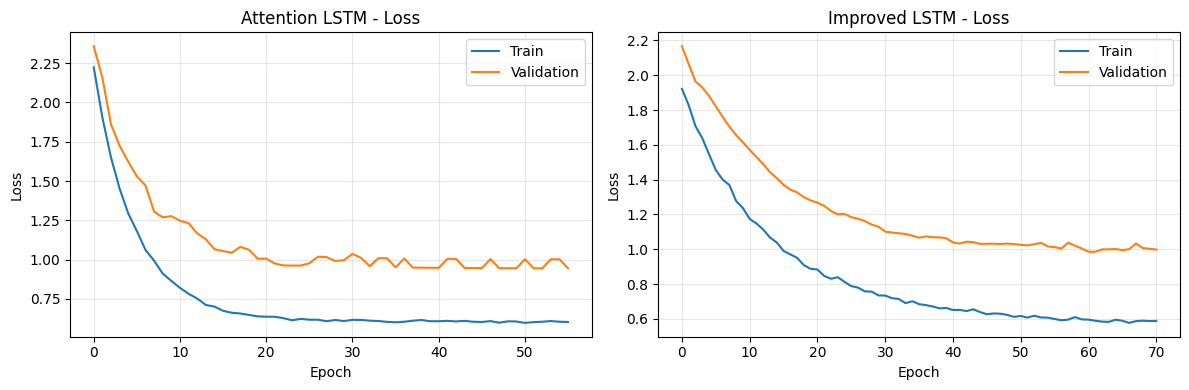


=== 성능 요약 ===
Attention LSTM Hit-rate: 0.548
Improved LSTM Hit-rate: 0.548
Ensemble Hit-rate: 0.548


In [17]:
# -------- 학습 곡선 --------
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history_attn.history['loss'], label='Train')
axes[0].plot(history_attn.history['val_loss'], label='Validation')
axes[0].set_title('Attention LSTM - Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(history_imp.history['loss'], label='Train')
axes[1].plot(history_imp.history['val_loss'], label='Validation')
axes[1].set_title('Improved LSTM - Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== 성능 요약 ===")
print(f"Attention LSTM Hit-rate: {hit_attn:.3f}")
print(f"Improved LSTM Hit-rate: {hit_imp:.3f}")
print(f"Ensemble Hit-rate: {hit_ens:.3f}")